In [1]:
# 1. Выбрать задачу (классификация или регрессия), датасет (пересечений не должно быть - у каждого студента свой датасет)
# и метрику качества

# Мой выбор - регрессия и метрика R2
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import sklearn
import warnings
warnings.simplefilter("ignore")
%matplotlib inline

sns.set(style="darkgrid")
data = pd.read_csv("cwurData.csv")
data.head()

,world_rank,institution,country,national_rank,quality_of_education,alumni_employment,quality_of_faculty,publications,influence,citations,broad_impact,patents,score,year
0,1,Harvard University,USA,1,7,9,1,1,1,1,NaN,5,100.00,2012
1,2,Massachusetts Institute of Technology,USA,2,9,17,3,12,4,4,NaN,1,91.67,2012
2,3,Stanford University,USA,3,17,11,5,4,2,2,NaN,15,89.50,2012
3,4,University of Cambridge,United Kingdom,1,10,24,4,16,16,11,NaN,50,86.17,2012
4,5,California Institute of Technology,USA,4,2,29,7,37,22,22,NaN,18,85.21,2012


In [2]:
data.shape

(2200, 14)

In [3]:
# 2. Сделать препроцессинг, фичеинжинириг и т.д. \\ разрешается использование любых пакетов
data.isna().sum()

world_rank                0
institution               0
country                   0
national_rank             0
quality_of_education      0
alumni_employment         0
quality_of_faculty        0
publications              0
influence                 0
citations                 0
broad_impact            200
patents                   0
score                     0
year                      0
dtype: int64

In [4]:
categorical = list(data.dtypes[data.dtypes == "object"].index)

a = data[categorical]
a = pd.get_dummies(a)

def change(a):
    if np.isnan(a)==True:
            return 0
    else:
        return a
    
data = data.drop(columns=categorical)

data = data.join(a)

In [5]:
data.dtypes

world_rank                      int64
national_rank                   int64
quality_of_education            int64
alumni_employment               int64
quality_of_faculty              int64
                                ...  
country_USA                     uint8
country_Uganda                  uint8
country_United Arab Emirates    uint8
country_United Kingdom          uint8
country_Uruguay                 uint8
Length: 1095, dtype: object

In [6]:
y = data["score"]
X = data.drop(columns=["score","broad_impact"])

from sklearn.model_selection import train_test_split

numeric_features = data.select_dtypes(include=np.number).columns.tolist()
X_nf = data[numeric_features]
numeric_features = X_nf.columns
X_nf = X_nf.fillna(method='ffill')
X_nf.isna().mean()

X_train, X_test, y_train, y_test = train_test_split(X_nf, y, test_size=0.3, random_state=10)

In [7]:
for i in list(X_train.columns):
    X_test[i] = X_test[i].agg(change)
    X_train[i] = X_train[i].agg(change)
    y_train = y_train.agg(change)
    y_test = y_test.agg(change)

In [8]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

sc.fit(X_train)
X_train_sc = sc.transform(X_train)
X_test_sc  = sc.transform(X_test)

<AxesSubplot:xlabel='score', ylabel='Density'>

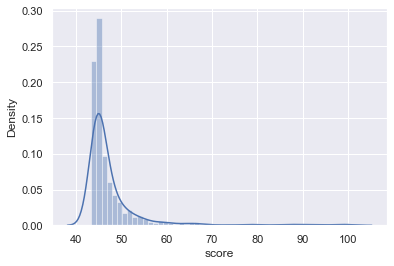

In [9]:
# 2*. Посчитать различные статистики, визуализировать данные и сделать первичные выводы \\ разрешается использование любых пакетов
sns.distplot(y_train)

In [10]:
# 3. Реализовать метрику качества \\ аргументировать выбор метрики качества
# метрика р2 используется в реализации лин регрессии и поэтому очень удобна для сравнения
def r2(real, predicted):
    Sum1 = np.sum((predicted - real) ** 2)
    Sum2 = np.sum((real - np.mean(real)) ** 2)

    r2 = 1 - Sum1 / Sum2

    return r2

In [11]:
# 4. Реализовать и обучить логистическую регрессию или линейную регрессию \\ !!!не разрешается использовать sklearn!!!
def predict_y(x, weight, bias):
    return weight*x + bias

def cost_function(x, y, weight, bias):
    companies = len(x)
    total_error = 0.0
    for i in range(companies):
        total_error += (y[i] - (weight*x[i] + bias))**2
    return total_error / companies

In [12]:
def update_weights(x, y, weight, bias, learning_rate):
    weight_deriv = 0
    bias_deriv = 0
    companies = len(x)

    for i in range(companies):
        # Вычисление частных производных
        # -2x(y - (mx + b))
        weight_deriv += -2*x[i] * (y[i] - (weight*x[i] + bias))

        # -2(y - (mx + b))
        bias_deriv += -2*(y[i] - (weight*x[i] + bias))

    # Мы вычитаем, потому что производные указывают в направлении самого крутого подъема
    weight -= (weight_deriv / companies) * learning_rate
    bias -= (bias_deriv / companies) * learning_rate

    return weight, bias

In [13]:
def train(x, y, weight, bias, learning_rate, iters):
    cost_history = []

    for i in range(iters):
        weight,bias = update_weights(x, y, weight, bias, learning_rate)

        #Calculate cost for auditing purposes
        cost = cost_function(x, y, weight, bias)
        cost_history.append(cost)

        # Log Progress
        if i % 10 == 0:
            print("iter={}    weight={}    bias={}    cost={}".format(i, weight, bias, cost))
            

    return weight, bias, cost_history, score

In [16]:
x = X_train_sc
y = y_train.values
for i in range(len(x)):
    for k in range(len(x[i])):
        if np.isnan(x[i][k])==True:
            x[i][k]=0
for i in range(len(y)):
    if np.isnan(y[i])==True:
            y[i]=0
weight = 0 # веса
bias = 0 # сдвиг
lr = 0.01 # качество обучения
iters = 100 # итерации
score = [] # оценка
weight, bias, cost_history, score = train(x,y,weight,bias,lr,iters)

iter=0    weight=[-0.08267003 -0.02985125 -0.08813122 ... -0.00255609  0.00324657
 -0.00253084]    bias=[0.95528247 0.95528247 0.95528247 ... 0.95528247 0.95528247 0.95528247]    cost=[2248.0245323  2248.61291276 2247.93218731 ... 2248.70048453 2248.70008787
 2248.70049724]
iter=10    weight=[-0.82367726 -0.29742087 -0.87808944 ... -0.0254674   0.03234695
 -0.0252159 ]    bias=[9.51789235 9.51789235 9.51789235 ... 9.51789235 9.51789235 9.51789235]    cost=[1514.27683387 1519.60835283 1513.44006394 ... 1520.4018709  1520.39827668
 1520.4019861 ]
iter=20    weight=[-1.42913412 -0.51604473 -1.52354281 ... -0.04418761  0.05612408
 -0.04375124]    bias=[16.51416804 16.51416804 16.51416804 ... 16.51416804 16.51416804
 16.51416804]    cost=[1024.42102114 1032.91909718 1023.08726718 ... 1034.18391063 1034.17818168
 1034.18409424]
iter=30    weight=[-1.92383645 -0.69467635 -2.05092522 ... -0.05948339  0.07555173
 -0.05889596]    bias=[22.23063465 22.23063465 22.23063465 ... 22.23063465 22.23063

In [17]:
# 4*. Добавить регуляризацию \\ не разрешается использовать sklearn

In [18]:
# 5. Оценить качество модели на обучающей и тестовой выборках \\ не разрешается использовать sklearn
x = X_test_sc
y = y_test.values
for i in range(len(x)):
    for k in range(len(x[i])):
        if np.isnan(x[i][k])==True:
            x[i][k]=0
for i in range(len(y)):
    if np.isnan(y[i])==True:
            y[i]=0
predict_y (x, weight, bias)

array([[45.61526368, 42.37241975, 44.15219332, ..., 41.43366408,
        41.39276117, 41.4336246 ],
       [38.98212911, 41.91784376, 38.46816225, ..., 41.43366408,
        41.39276117, 41.4336246 ],
       [38.03453846, 41.58953889, 38.46816225, ..., 41.43366408,
        41.39276117, 41.4336246 ],
       ...,
       [36.57761783, 40.75614958, 38.46816225, ..., 41.43366408,
        41.39276117, 41.4336246 ],
       [35.81954531, 41.23597979, 38.84293353, ..., 41.43366408,
        41.39276117, 41.4336246 ],
       [46.2311976 , 41.64004733, 47.96236799, ..., 41.43366408,
        41.39276117, 41.4336246 ]])

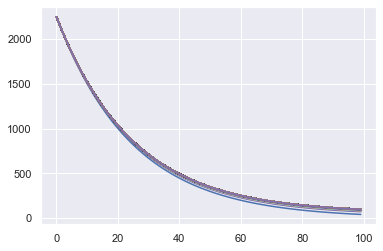

In [19]:
# 5*. Сделать график ошибки модели на обучающей и тестовой выборках 
# 5*. Сделать график точности модели на обучающей и тестовой выборках
plt.plot(cost_history)
plt.grid(True)
plt.show()

In [20]:
# 6. Обучить логистическую регрессию или линейную регрессию из sklearn, оценить качество модели на 
# обучающей и тестовой выборках и сравнить со своей моделью
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

lr = linear_model.LinearRegression()
lr.fit(X_train_sc, y_train)
print ("LinearRegression:", lr.score(X_test_sc, y_test))
print ("LR RMSE:", np.sqrt(mean_squared_error(lr.predict(X_test_sc), y_test)))

LinearRegression: 0.9949457131891914
LR RMSE: 0.5783901071473211


In [21]:
# 6*. Сделать график ошибки модели из sklearn на обучающей и тестовой выборках и сравнить со своей моделью
# 6*. Сделать график точности модели из sklearn на обучающей и тестовой выборках и сравнить со своей моделью

<AxesSubplot:xlabel='score', ylabel='Density'>

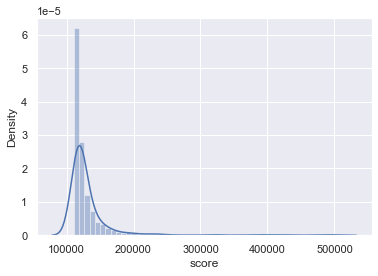

In [22]:
error = (y_train - lr.predict(X_train)) ** 2
sns.distplot(error)

<AxesSubplot:xlabel='score', ylabel='Density'>

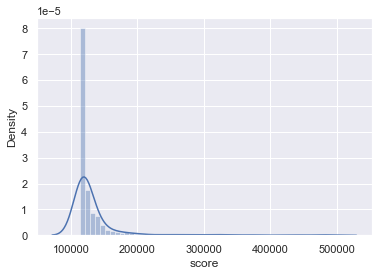

In [23]:
error = (y_test - lr.predict(X_test)) ** 2
sns.distplot(error)